# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.metrics import roc_auc_score
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Importing and Exploring the Dataset

In [2]:
data=pd.read_csv('heatdata_nb.csv',encoding='latin-1')
data.head(n=6)

,Heat_Related_Illness,CCUpdates
0,True,Pt to ed by EMS; patient was walking in the he...
1,False,H60.333 Swimmer's ear; bilateral
2,False,Migraine G43.909 Migraine; unspecified; not in...
3,False,SOB I50.9 Heart failure; unspecified
4,True,dizzy T67.5XXA HEAT EXHAUSTION; UNSPECIFIED; I...
5,False,pt reports that he is trying to detox from ETO...


## Convert the logical variable to a categorical variable
0 for false and 1 for true

In [3]:
data['Heat_Related_Illness']=data['Heat_Related_Illness']*1

# Distribution true/false plots


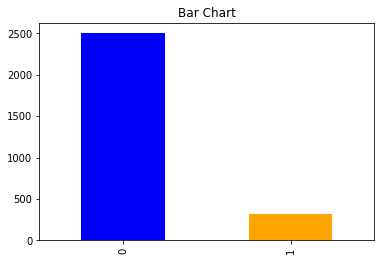

In [4]:
count_Class=pd.value_counts(data["Heat_Related_Illness"],sort=True)
count_Class.plot(kind='bar',color=["blue","orange"])
plt.title("Bar Chart")
plt.show()

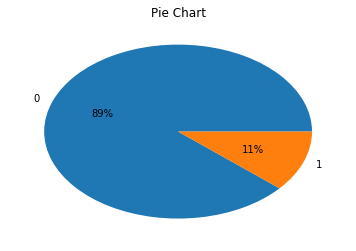

In [5]:
count_Class.plot(kind='pie',autopct='%1.0f%%')
plt.title('Pie Chart')
plt.ylabel('')
plt.show()

# Text Analytics

We want to find the fewquencies of words in the chief complaints of true and false heat related illness. The words of the chief complaints will be model features.

We use the function Counter.

In [6]:
count1=Counter("".join(data[data['Heat_Related_Illness']==0]["CCUpdates"]).split()).most_common(20)
df1=pd.DataFrame.from_dict(count1)
df1=df1.rename(columns={0: "False", 1: "count"})
count2=Counter("".join(data[data['Heat_Related_Illness']==1]['CCUpdates']).split()).most_common(20)
df2=pd.DataFrame.from_dict(count2)
df2=df2.rename(columns={0: "True", 1: "count"})

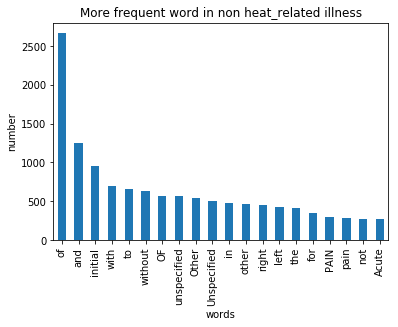

In [7]:
df1.plot.bar(legend=False)
y_pos=np.arange(len(df1["False"]))
plt.xticks(y_pos,df1["False"])
plt.title("More frequent word in non heat_related illness")
plt.xlabel('words')
plt.ylabel('number')
plt.show()

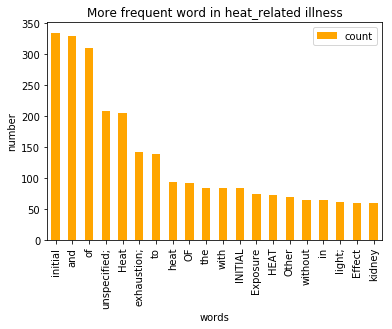

In [8]:
df2.plot.bar(legend=True,color='orange')
y_pos=np.arange(len(df2["True"]))
plt.xticks(y_pos,df2["True"])
plt.title("More frequent word in heat_related illness")
plt.xlabel('words')
plt.ylabel('number')
plt.show()

### We can see that the majority of frequent words in both classes are stop words such as 'and', 'to', 'of' and so on. 
With stop words we refer to the most common words in a language, there is no universal list of stop words.


# Feature Extraction

### We remove the stop words in order to improve prediction accuracy.

In [9]:
f=feature_extraction.text.CountVectorizer(stop_words='english',lowercase=True)
X=f.fit_transform(data['CCUpdates'])
np.shape(X)

(2819, 6480)

# Predictive Analysis

The variable Heat_Related_Illness is already a binary variable. We then spilt the data set in training set and test set.

In [10]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,data['Heat_Related_Illness'],test_size=0.35,random_state=789)
#print([np.shape(y_train),np.shape(y_test)])

# Support Vector Machine

We apply the support vector machine model with the gaussian kernel.

We train different models with various regularization parameter C.

We evaluate the accuracy, sensitivity (recall), specificity, and precision of the model with test set.

In [11]:
list_C = np.arange(500, 2000, 100) #100000
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

We look at the first 5 learning models and their metrics.

In [12]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Sensitivity', 'Test Precision'])
models.head(n=5)

,C,Train Accuracy,Test Accuracy,Test Sensitivity,Test Precision
0,500.0,0.992358,0.982776,0.880342,0.971698
1,600.0,0.993450,0.982776,0.880342,0.971698
2,700.0,0.993450,0.982776,0.880342,0.971698
3,800.0,0.993996,0.980750,0.871795,0.962264
4,900.0,0.995087,0.980750,0.871795,0.962264


### Select the model with the highest sensitivity.

In [13]:
best_index = models['Test Sensitivity'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(X_train, y_train)
models.iloc[best_index, :]

C                   500.000000
Train Accuracy        0.992358
Test Accuracy         0.982776
Test Sensitivity      0.880342
Test Precision        0.971698
Name: 0, dtype: float64

### Confusion matrix with support vector machine classifier.

In [14]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,867,3
Actual 1,14,103


The sensitivity is 88.03% and the specificity is 99.66%, with accuracy 98.27 and precision 97.17%.

### The area under the curve (AUC)

In [15]:
roc_auc_score(y_test,svc.predict(X_test))

0.9384468022399057